In [82]:
# import packages
import glob
from pathlib import Path
import os
import geopandas as gpd
import iris
import iris.pandas
import numpy as np
from esmvalcore import preprocessor
from iris.coords import DimCoord
from iris.cube import Cube
from pathos.threading import ThreadPool as Pool
from datetime import datetime
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import iris.plot as iplt
import matplotlib.pyplot as plt
import iris.quickplot as qplt

In [83]:
work_dir=Path("/scratch/fransjevanoors/global_sr")

In [84]:
cb = pd.read_csv(f"{work_dir}/output/forcing_timeseries/cru_p/mean_p.csv",index_col=0)
cb['dif'] = cb['cru_mean_p_aw']-cb['cru_mean_p_nn']
cb['dif_rel'] = cb['dif']/cb['cru_mean_p_nn'] *100
cb

,cru_mean_p_aw,cru_mean_p_nn,dif,dif_rel
ch_0000103,3.898726,3.890731,0.007995,0.205484
us_0002154,3.928862,3.923121,0.005742,0.146351
ca_0003144,1.139313,1.139023,0.000290,0.025442
us_0000227,3.305487,3.305487,0.000000,0.000000
de_0000803,1.962505,1.962505,0.000000,0.000000
...,...,...,...,...
ca_0000756,2.681718,2.672363,0.009355,0.350078
fr_0000894,2.470836,2.466738,0.004098,0.166134
br_0003043,5.130479,4.980619,0.149860,3.008868
ca_0001736,4.072753,4.085046,-0.012293,-0.300931


Text(0, 0.5, 'nearest neighbour mean p')

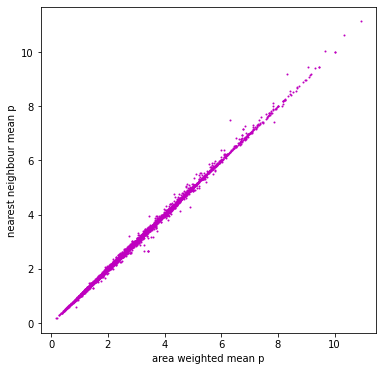

In [85]:
fig=plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(cb['cru_mean_p_aw'],cb['cru_mean_p_nn'],'mo',markersize=1)
ax.set_xlabel('area weighted mean p')
ax.set_ylabel('nearest neighbour mean p')

In [86]:
cc = pd.read_csv(f"{work_dir}/output/catchment_characteristics.csv",index_col=0)
a = cc.area
cb = cb.drop(index=['br_0000147', 'br_0000267', 'br_0000145', 'br_0000026', 'om_0000004', 'br_0000044', 'br_0000024', 'om_0000001', 'br_0000269', 'om_0000005', 'br_0000092', 'br_0000260', 'br_0000243', 'br_0000246', 'br_0000097', 'br_0000025', 'br_0000112', 'br_0000094', 'br_0000133', 'br_0000126', 'br_0000167', 'br_0000125', 'br_0000262', 'om_0000006', 'br_0000104', 'br_0000017', 'pa_0000002', 'br_0000265', 'br_0000266', 'br_0000093', 'br_0000270', 'br_0000257', 'br_0000155', 'br_0000053', 'br_0000139', 'br_0000049', 'br_0000247', 'br_0000018', 'br_0000102', 'br_0000263', 'br_0000101', 'br_0000158', 'br_0000165', 'br_0000109', 'br_0000259', 'br_0000096', 'br_0000088', 'br_0000137', 'br_0000146', 'br_0000099', 'br_0000048', 'om_0000002', 'br_0000143', 'br_0000086', 'pa_0000001', 'pa_0000004', 'br_0000135', 'br_0000130', 'br_0000129', 'br_0000132', 'br_0000089', 'br_0000111', 'br_0000162', 'br_0000022', 'br_0000153', 'br_0000124', 'br_0000090', 'br_0000058', 'om_0000007', 'br_0000244', 'br_0000150', 'br_0000055', 'br_0000050', 'br_0000020', 'br_0000148', 'br_0000151', 'br_0000103', 'br_0000107', 'br_0000252', 'br_0000121', 'br_0000128', 'br_0000091', 'br_0000118', 'br_0000117', 'br_0000253', 'br_0000166', 'br_0000136', 'br_0000123', 'pa_0000003', 'br_0000264', 'br_0000168', 'br_0000016', 'br_0000087', 'om_0000008', 'br_0000116'])

(0.0, 10000.0)

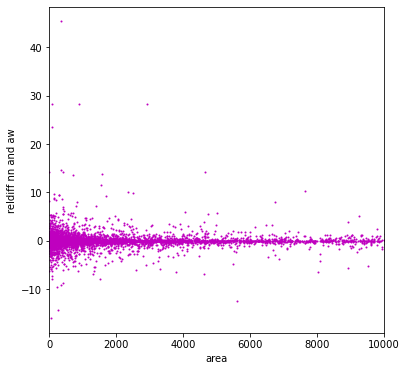

In [87]:
fig=plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(a,cb['dif_rel'],'mo',markersize=1)
ax.set_xlabel('area')
ax.set_ylabel('reldiff nn and aw')
ax.set_xlim(0,10000)
# verschillen best groot voor kleine catchments -> wat is beter NN or AW???

In [88]:
# select catch ids with small area
cb_s = cb[cb['dif_rel']>5]
cb_s

,cru_mean_p_aw,cru_mean_p_nn,dif,dif_rel
br_0001114,2.849424,2.698533,0.150892,5.591620
br_0002170,3.630803,3.453064,0.177738,5.147266
218001,1.993956,1.832369,0.161587,8.818470
es_0001007,2.585292,2.458266,0.127026,5.167318
za_0000110,1.489775,1.303728,0.186047,14.270387
...,...,...,...,...
ca_0005369,1.774462,1.553345,0.221116,14.234837
ca_0005795,1.358468,1.281082,0.077386,6.040698
es_0000457,1.089912,1.003842,0.086070,8.574012
es_0001008,2.429534,2.243867,0.185667,8.274423


In [89]:
def regridding_target_cube(catchment_shapefile, spatial_resolution, buffer=1):
    
    """
    Define the target cube for regridding the input netcdf data
    catchment_shapefile:  str, catchment shapefile
    spatial_resolution:   float, target resolution
    buffer:               int, buffer
    
    returns:
    target cube for regridding
    
    """    
    catchment_bounds = gpd.read_file(catchment_shapefile).bounds

    buffer = 1
    minx = int(catchment_bounds.minx.values[0]) - buffer
    maxx = int(catchment_bounds.maxx.values[0]) + buffer
    miny = int(catchment_bounds.miny.values[0]) - buffer
    maxy = int(catchment_bounds.maxy.values[0]) + buffer

    latitude = DimCoord(
        np.linspace(
            miny,
            maxy,
            int(np.divide(abs(miny-maxy), spatial_resolution)),
            dtype=float,
        ),
        standard_name="latitude",
        units="degrees",
    )
    latitude.guess_bounds()
    
    longitude = DimCoord(
        np.linspace(
            minx,
            maxx,
            int(np.divide(abs(minx-maxx), spatial_resolution)),
            dtype=float,
        ),
        standard_name="longitude",
        units="degrees",
    )
    longitude.guess_bounds()
    
    target_cube = Cube(
        np.zeros((len(latitude.points), len(longitude.points)), np.float32),
        dim_coords_and_dims=[(latitude, 0), (longitude, 1)],
    )

    return target_cube

/home/fransjevanoors/.conda/envs/sr_env/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/fransjevanoors/.conda/envs/sr_env/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/fransjevanoors/.conda/envs/sr_env/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/fransjevanoors/.conda/envs/sr_env/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/fransjevanoors/.conda/envs/sr_env/lib/python3.9/site-packages/

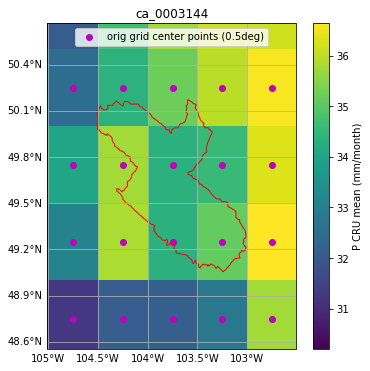

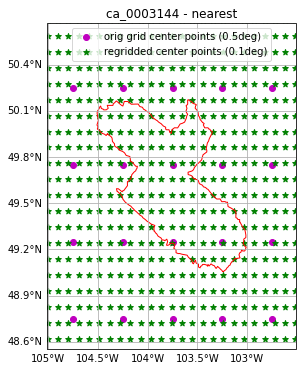

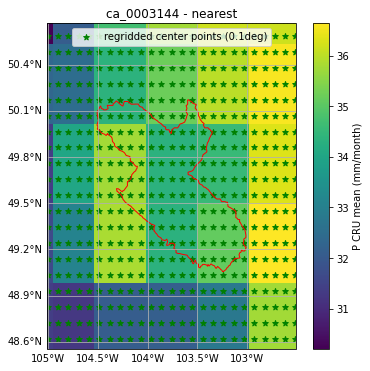

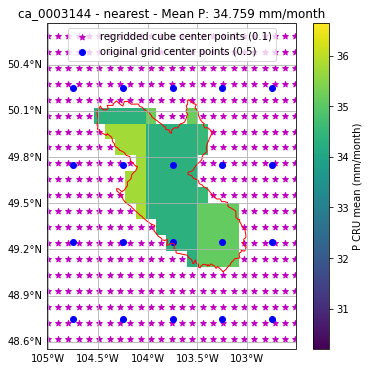

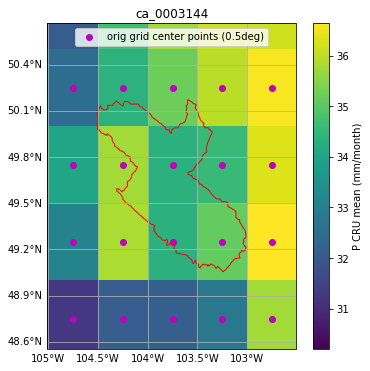

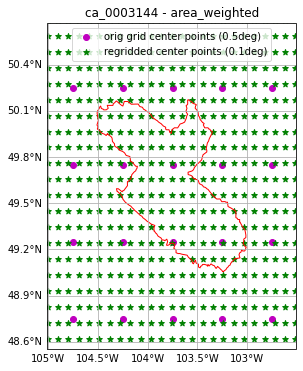

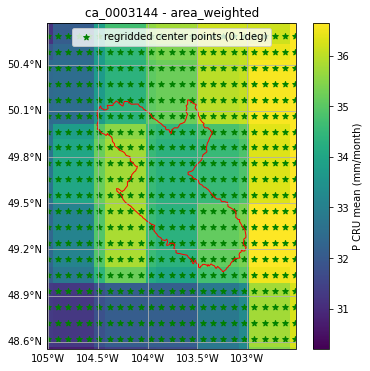

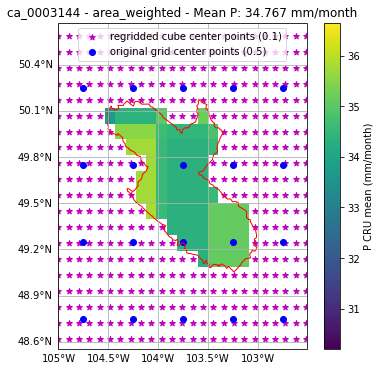

In [81]:
grid_resolution_o=0.5
grid_resolution_t=0.1
catch_id = 'ca_0003144'
regrid_method='nearest'
map_grid_to_catchment(catch_id,grid_resolution_o,grid_resolution_t,regrid_method)

regrid_method='area_weighted'
map_grid_to_catchment(catch_id,grid_resolution_o,grid_resolution_t,regrid_method)

In [76]:
def map_grid_to_catchment(catch_id,grid_resolution_o,grid_resolution_t,regrid_method):
    if not os.path.exists(f'{work_dir}/output/figures/grid_to_catchment_figures/{catch_id}'):
        os.makedirs(f'{work_dir}/output/figures/grid_to_catchment_figures/{catch_id}')
    
    # load catchment shapefile
    catchment_shapefile = (f'{work_dir}/output/selected_shapes/{catch_id}.shp')
    c = gpd.read_file(catchment_shapefile)
    xmin, xmax = c.bounds.minx.values[0], c.bounds.maxx.values[0]
    ymin, ymax = c.bounds.miny.values[0], c.bounds.maxy.values[0]
    
    # make cube from netcdf
    catchment_netcdf = f'{work_dir}/data/cru_p/cru_ts4.06_1961_2010_pre.nc'
    cube1 = iris.load_cube(catchment_netcdf)
    cube1.dim_coords[1].guess_bounds()
    cube1.dim_coords[2].guess_bounds()

    # select relevant part of cube for mapping
    cube1_extract = cube1.intersection(latitude=(ymin-0.5,ymax+0.5), longitude=(xmin-0.5,xmax+0.5))

    # take time-mean of cube1 for mapping
    cube1_tmean = cube1_extract.collapsed('time', iris.analysis.MEAN)
    vmin = cube1_tmean.data.min()
    vmax = cube1_tmean.data.max()

    # plot shape and global original grid
    fig = plt.figure(figsize=(6,6))
    geo_axes = plt.axes(projection=cartopy.crs.PlateCarree())
    im = iplt.pcolormesh(cube1_tmean[:,:,:],axes=geo_axes,vmin=vmin,vmax=vmax,cmap='viridis')
    fig.colorbar(im, ax=geo_axes, location='right', label='P CRU mean (mm/month)')
    iplt.points(cube1[0,:,:],axes=geo_axes,color='m',marker='o',label='orig grid center points ('+str(grid_resolution_o)+'deg)')
    c.plot(ax=geo_axes, facecolor='none',edgecolor='red', label='catchment shape')
    gl = geo_axes.gridlines(draw_labels=True)
    geo_axes.set_extent((xmin-0.5,xmax+0.5,ymin-0.5,ymax+0.5))
    gl.top_labels = False
    gl.right_labels = False
    geo_axes.legend(loc=9)
    geo_axes.set_title(f'{catch_id}')
    fig.savefig(f'{work_dir}/output/figures/grid_to_catchment_figures/{catch_id}/fig1_cru_p_{regrid_method}.jpg',bbox_inches='tight',dpi=300)
    
    # regrid - nearest
    target_cube = regridding_target_cube(catchment_shapefile, grid_resolution_t, buffer=1) #create the regrid target cube
    cube2 = preprocessor.regrid(cube1, target_cube, scheme=regrid_method) #regrid the netcdf file (nearest neighbour or area weighted) to a higher resolution

    # plot regridded cube centerpoints
    fig = plt.figure(figsize=(6,6))
    geo_axes = plt.axes(projection=cartopy.crs.PlateCarree())
    iplt.points(cube1[0,:,:],axes=geo_axes,color='m',marker='o',label='orig grid center points ('+str(grid_resolution_o)+'deg)')
    # iplt.points(target_cube[:,:],axes=geo_axes,color='g',marker='s',label='target cube center points')
    iplt.points(cube2[0,:,:],axes=geo_axes,color='g',marker='*',label='regridded center points ('+str(grid_resolution_t)+'deg)')
    c.plot(ax=geo_axes, facecolor='none',edgecolor='red')
    gl = geo_axes.gridlines(draw_labels=True)
    geo_axes.set_extent((xmin-0.5,xmax+0.5,ymin-0.5,ymax+0.5))
    gl.top_labels = False
    gl.right_labels = False
    geo_axes.legend(loc=9)
    geo_axes.set_title(f'{catch_id} - {regrid_method}')
    fig.savefig(f'{work_dir}/output/figures/grid_to_catchment_figures/{catch_id}/fig2_cru_p_{regrid_method}.jpg',bbox_inches='tight',dpi=300)
    
    # plot regridded cube centerpoints + mean p values
    cube2_tmean = cube2.collapsed('time', iris.analysis.MEAN)

    fig = plt.figure(figsize=(6,6))
    geo_axes = plt.axes(projection=cartopy.crs.PlateCarree())
    im = iplt.pcolormesh(cube2_tmean[:,:,:],axes=geo_axes,vmin=vmin,vmax=vmax,cmap='viridis')
    fig.colorbar(im, ax=geo_axes, location='right', label='P CRU mean (mm/month)')
    # iplt.points(cube1[0,:,:],axes=geo_axes,color='m',marker='o',label='orig grid center points ('+str(grid_resolution_or)+'deg)')
    iplt.points(cube2[0,:,:],axes=geo_axes,color='g',marker='*',label='regridded center points ('+str(grid_resolution)+'deg)')
    c.plot(ax=geo_axes, facecolor='none',edgecolor='red')
    gl = geo_axes.gridlines(draw_labels=True)
    geo_axes.set_extent((xmin-0.5,xmax+0.5,ymin-0.5,ymax+0.5))
    gl.top_labels = False
    gl.right_labels = False
    geo_axes.legend(loc=9)
    geo_axes.set_title(f'{catch_id} - {regrid_method}')
    fig.savefig(f'{work_dir}/output/figures/grid_to_catchment_figures/{catch_id}/fig3_cru_p_{regrid_method}.jpg',bbox_inches='tight',dpi=300)
    
    # extract shape from regridded cube
    cube3 = preprocessor.extract_shape(cube2, catchment_shapefile, method="contains")
    cube3_tmean = cube3.collapsed('time', iris.analysis.MEAN)

    # plot final cube + mean p
    fig = plt.figure(figsize=(6,6))
    geo_axes = plt.axes(projection=cartopy.crs.PlateCarree())
    # iplt.points(target_cube[:,:],axes=geo_axes,color='g',marker='s')
    iplt.points(cube2[0,:,:],axes=geo_axes,color='m',marker='*',label='regridded cube center points ('+str(grid_resolution)+')')
    # iplt.points(cube3[0,:,:],axes=geo_axes,color='black',marker='^',label='regridded + extracted shape cube center points')
    im = iplt.pcolormesh(cube3_tmean[:,:,:],axes=geo_axes,vmin=vmin,vmax=vmax,cmap='viridis')
    fig.colorbar(im, ax=geo_axes, location='right', label='P CRU mean (mm/month)')
    iplt.points(cube1[0,:,:],axes=geo_axes,color='blue',marker='o',label='original grid center points ('+str(grid_resolution_or)+')')
    c.plot(ax=geo_axes, facecolor='none',edgecolor='red')
    gl = geo_axes.gridlines(draw_labels=True)
    geo_axes.set_extent((xmin-0.5,xmax+0.5,ymin-0.5,ymax+0.5))
    gl.top_labels = False
    gl.right_labels = False
    geo_axes.legend(loc=9)
    geo_axes.set_title(f'{catch_id} - {regrid_method} - Mean P: {np.round(cube3[:,:,:].data.mean(),3)} mm/month')
    fig.savefig(f'{work_dir}/output/figures/grid_to_catchment_figures/{catch_id}/fig4_cru_p_{regrid_method}.jpg',bbox_inches='tight',dpi=300)